In [1]:
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
six_years_stat = pd.read_csv('/home/harishramani/Documents/work/prototype/data/big5_last_6_years_result_latest.csv')
manager_info = pd.read_csv('/home/harishramani/Documents/work/prototype/data/manager_df_full_latest.csv')

In [3]:
# Remove matches that haven't been played yet (rescheduled to a later date)
six_years_stat = six_years_stat[six_years_stat.match_report_url.isna()!=True]
manager_info = manager_info[manager_info.url.isna()!=True]

In [4]:
# Join the dataframes
six_year_stats_merged = pd.merge(six_years_stat, manager_info, left_on = 'match_report_url', right_on='url', how='inner')
six_year_stats_merged = six_year_stats_merged[(six_year_stats_merged.home_manager.isna()!=True) & (six_year_stats_merged.away_manager.isna()!=True)]

In [5]:
six_year_stats_merged.to_csv('merged_manager_stats_last_6_years.csv', index=False)

In [6]:
def determine_result(score):
  emDash = '–'
  scores = score.strip().split(emDash)
  scores = [int(s.strip().replace(' ', '')) for s in scores]
  if scores[0] > scores[1]:
    return "HOME"
  elif scores[0] < scores[1]:
    return "AWAY"
  return "DRAW"

In [7]:
six_year_stats_merged['date'] = pd.to_datetime(six_year_stats_merged['date'])
six_year_stats_merged['result'] = six_year_stats_merged['score'].map(determine_result)

In [8]:
six_year_stats_merged['date'].min()

Timestamp('2017-08-04 00:00:00')

In [9]:
six_year_stats_merged['xg_delta'] = six_year_stats_merged['home_xg'] - six_year_stats_merged['away_xg']
six_year_stats_merged["year"] = six_year_stats_merged["year"].apply(lambda x: "CURRENT" if pd.isna(x) or x == '' else x)

In [10]:
all_managers = list(set(six_year_stats_merged['home_manager']).union(set(six_year_stats_merged['away_manager'])))
all_teams = list(set(six_year_stats_merged['home_team']).union(set(six_year_stats_merged['away_team'])))
all_league = six_year_stats_merged['league'].unique()

In [11]:
def find_manager_for_a_match(row, team_name):
  if row['home_team'] == team_name:
    return row['home_manager']
  elif row['away_team'] == team_name:
    return row['away_manager']
  return None

In [12]:
def find_if_there_is_a_change_in_manager(df, team_name, interim_short_change_threshold = 3):
  matches = df[(df.home_team == team_name) | (df.away_team == team_name)]
  matches = matches.sort_values(["date"], ascending=True).reset_index(drop=True)
  matches['manager'] = matches.apply(lambda x: find_manager_for_a_match(x, team_name), axis=1)
  current_manager = find_manager_for_a_match(matches.iloc[0], team_name)
  sack = [False]
  midseason_sack = [False]
  for index, row in matches[1:].iterrows():
    manager_for_the_game = row['manager']
    if manager_for_the_game!=current_manager:
      next_threshold_matches = matches.iloc[index: index+interim_short_change_threshold]
      next_threshold_matches['manager'] = next_threshold_matches.apply(lambda x: find_manager_for_a_match(x, team_name), axis=1)
      if current_manager not in list(next_threshold_matches['manager'].unique()):
        sack.append(True)
        if (row['date'].month!=8) : # Check for pandemic season.
          if (row['date'].month==9) and (row['date'].year == 2020):
            midseason_sack.append(False)
          else:
            midseason_sack.append(True)
        else:
          midseason_sack.append(False)
        current_manager = manager_for_the_game
      else:
        sack.append(False)
        midseason_sack.append(False)
    else:
      sack.append(False)
      midseason_sack.append(False)
  matches["is_new_manager"] = sack
  matches["is_mid_season_sack"] = midseason_sack
  return matches


In [13]:
team_timeline = {}
for team in tqdm(all_teams):
  team_timeline[team] = find_if_there_is_a_change_in_manager(six_year_stats_merged, team)

100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 54.93it/s]


In [14]:
manager_timeline = []
for mgr in tqdm(all_managers):
  home_matches = six_year_stats_merged[six_year_stats_merged.home_manager==mgr]
  away_matches = six_year_stats_merged[six_year_stats_merged.away_manager==mgr]
  teams_represented = set(home_matches['home_team']).union(set(away_matches['away_team']))
  for team in list(teams_represented):
    home_matches_team = home_matches[home_matches.home_team == team]
    away_matches_team = away_matches[away_matches.away_team == team]
    home_results= home_matches_team['result'].value_counts()
    away_results = away_matches_team['result'].value_counts()
    avg_home_xg_created = home_matches_team.groupby(['result'])['home_xg'].mean()
    avg_home_xg_faced = home_matches_team.groupby(['result'])['away_xg'].mean()
    avg_away_xg_faced = away_matches_team.groupby(['result'])['home_xg'].mean()
    avg_away_xg_created = away_matches_team.groupby(['result'])['away_xg'].mean()
    median_home_xg_created = home_matches_team.groupby(['result'])['home_xg'].median()
    median_home_xg_faced = home_matches_team.groupby(['result'])['away_xg'].median()
    median_away_xg_faced = away_matches_team.groupby(['result'])['home_xg'].median()
    median_away_xg_created = away_matches_team.groupby(['result'])['away_xg'].median()


    manager_timeline.append({
        "name": mgr,
        "team": team,
        "start_date": min([home_matches_team['date'].min(), away_matches_team['date'].min()]),
        "end_date": max([home_matches_team['date'].max(), away_matches_team['date'].max()]),
        "home_wins": home_results["HOME"] if "HOME" in home_results.keys() else 0,
        "away_wins": away_results["AWAY"] if "AWAY" in away_results.keys() else 0,
        "home_loss": home_results["AWAY"] if "AWAY" in home_results.keys() else 0,
        "away_loss": away_results["HOME"] if "HOME" in away_results.keys() else 0,
        "home_draws": home_results["DRAW"] if "DRAW" in home_results.keys() else 0,
        "away_draws": away_results["DRAW"] if "DRAW" in away_results.keys() else 0,
        "total_games": home_matches_team.shape[0] + away_matches_team.shape[0],
        "total_home_games": home_matches_team.shape[0],
        "total_away_games": away_matches_team.shape[0],
        "avg_xg_created_in_home_wins": avg_home_xg_created["HOME"] if "HOME" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_wins": avg_home_xg_faced["HOME"] if "HOME" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_wins": avg_away_xg_created["AWAY"] if "AWAY" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_wins": avg_away_xg_faced["AWAY"] if "AWAY" in avg_away_xg_faced.keys() else 0.0,
        "avg_xg_created_in_home_draws": avg_home_xg_created["DRAW"] if "DRAW" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_draws": avg_home_xg_faced["DRAW"] if "DRAW" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_draws": avg_away_xg_created["DRAW"] if "DRAW" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_draws": avg_away_xg_faced["DRAW"] if "DRAW" in avg_away_xg_faced.keys() else 0.0,
        "avg_xg_created_in_home_loss":avg_home_xg_created["AWAY"] if "AWAY" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_loss": avg_home_xg_faced["AWAY"] if "AWAY" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_loss": avg_away_xg_created["HOME"] if "HOME" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_loss":avg_away_xg_faced["HOME"] if "HOME" in avg_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_wins": median_home_xg_created["HOME"] if "HOME" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_wins": median_home_xg_faced["HOME"] if "HOME" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_wins": median_away_xg_created["AWAY"] if "AWAY" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_wins": median_away_xg_faced["AWAY"] if "AWAY" in median_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_draws": median_home_xg_created["DRAW"] if "DRAW" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_draws": median_home_xg_faced["DRAW"] if "DRAW" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_draws": median_away_xg_created["DRAW"] if "DRAW" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_draws": median_away_xg_faced["DRAW"] if "DRAW" in median_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_loss":median_home_xg_created["AWAY"] if "AWAY" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_loss": median_home_xg_faced["AWAY"] if "AWAY" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_loss": median_away_xg_created["HOME"] if "HOME" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_loss":median_away_xg_faced["HOME"] if "HOME" in median_away_xg_faced.keys() else 0.0,

    })
manager_timeline_df = pd.DataFrame(manager_timeline)

100%|████████████████████████████████████████| 384/384 [00:03<00:00, 101.39it/s]


In [15]:
def get_manager_stats_for_matches(all_matches, manager_name, team_name):
  all_matches = all_matches.sort_values(['date'], ascending=True)
  home_matches_team = all_matches[all_matches.home_team == team_name]
  away_matches_team = all_matches[all_matches.away_team == team_name]
  home_results= home_matches_team['result'].value_counts()
  away_results = away_matches_team['result'].value_counts()
  avg_home_xg_created = home_matches_team.groupby(['result'])['home_xg'].mean()
  avg_home_xg_faced = home_matches_team.groupby(['result'])['away_xg'].mean()
  avg_away_xg_faced = away_matches_team.groupby(['result'])['home_xg'].mean()
  avg_away_xg_created = away_matches_team.groupby(['result'])['away_xg'].mean()
  median_home_xg_created = home_matches_team.groupby(['result'])['home_xg'].median()
  median_home_xg_faced = home_matches_team.groupby(['result'])['away_xg'].median()
  median_away_xg_faced = away_matches_team.groupby(['result'])['home_xg'].median()
  median_away_xg_created = away_matches_team.groupby(['result'])['away_xg'].median()
  home_min_date = home_matches_team['date'].min() if home_matches_team.shape[0] > 0 else pd.to_datetime('2099-01-01')
  away_min_date = away_matches_team['date'].min() if away_matches_team.shape[0] > 0 else pd.to_datetime('2099-01-01')
  home_max_date = home_matches_team['date'].max() if home_matches_team.shape[0] > 0 else pd.to_datetime('1999-01-01')
  away_max_date = away_matches_team['date'].max() if away_matches_team.shape[0] > 0 else pd.to_datetime('1999-01-01')


  return {
        "name": manager_name,
        "team": team_name,
        "start_date": min([home_min_date, away_min_date]),
        "end_date": max([home_max_date, away_max_date]),
        "home_wins": home_results["HOME"] if "HOME" in home_results.keys() else 0,
        "away_wins": away_results["AWAY"] if "AWAY" in away_results.keys() else 0,
        "home_loss": home_results["AWAY"] if "AWAY" in home_results.keys() else 0,
        "away_loss": away_results["HOME"] if "HOME" in away_results.keys() else 0,
        "home_draws": home_results["DRAW"] if "DRAW" in home_results.keys() else 0,
        "away_draws": away_results["DRAW"] if "DRAW" in away_results.keys() else 0,
        "total_games": home_matches_team.shape[0] + away_matches_team.shape[0],
        "total_home_games": home_matches_team.shape[0],
        "total_away_games": away_matches_team.shape[0],
        "avg_xg_created_in_home_wins": avg_home_xg_created["HOME"] if "HOME" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_wins": avg_home_xg_faced["HOME"] if "HOME" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_wins": avg_away_xg_created["AWAY"] if "AWAY" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_wins": avg_away_xg_faced["AWAY"] if "AWAY" in avg_away_xg_faced.keys() else 0.0,
        "avg_xg_created_in_home_draws": avg_home_xg_created["DRAW"] if "DRAW" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_draws": avg_home_xg_faced["DRAW"] if "DRAW" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_draws": avg_away_xg_created["DRAW"] if "DRAW" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_draws": avg_away_xg_faced["DRAW"] if "DRAW" in avg_away_xg_faced.keys() else 0.0,
        "avg_xg_created_in_home_loss":avg_home_xg_created["AWAY"] if "AWAY" in avg_home_xg_created.keys() else 0.0,
        "avg_xg_faced_in_home_loss": avg_home_xg_faced["AWAY"] if "AWAY" in avg_home_xg_faced.keys() else 0.0,
        "avg_xg_created_in_away_loss": avg_away_xg_created["HOME"] if "HOME" in avg_away_xg_created.keys() else 0.0,
        "avg_xg_faced_in_away_loss":avg_away_xg_faced["HOME"] if "HOME" in avg_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_wins": median_home_xg_created["HOME"] if "HOME" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_wins": median_home_xg_faced["HOME"] if "HOME" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_wins": median_away_xg_created["AWAY"] if "AWAY" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_wins": median_away_xg_faced["AWAY"] if "AWAY" in median_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_draws": median_home_xg_created["DRAW"] if "DRAW" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_draws": median_home_xg_faced["DRAW"] if "DRAW" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_draws": median_away_xg_created["DRAW"] if "DRAW" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_draws": median_away_xg_faced["DRAW"] if "DRAW" in median_away_xg_faced.keys() else 0.0,
        "median_xg_created_in_home_loss":median_home_xg_created["AWAY"] if "AWAY" in median_home_xg_created.keys() else 0.0,
        "median_xg_faced_in_home_loss": median_home_xg_faced["AWAY"] if "AWAY" in median_home_xg_faced.keys() else 0.0,
        "median_xg_created_in_away_loss": median_away_xg_created["HOME"] if "HOME" in median_away_xg_created.keys() else 0.0,
        "median_xg_faced_in_away_loss":median_away_xg_faced["HOME"] if "HOME" in median_away_xg_faced.keys() else 0.0,

    }


### How many mid season sacks occured in the last 6 years across different leagues.

In [16]:
midseason_sack_full = []
for team in tqdm(team_timeline.keys()):
  team_df = team_timeline[team]
  mid_sack_count = team_df[team_df.is_mid_season_sack==True].shape[0]
  new_managers_count = team_df[team_df.is_new_manager==True].shape[0]
  league = team_df['league'].unique()[0] # League name will be same for a team and will consist of only one entry.
  midseason_sack_full.append({
      "team_name": team,
      "num_mid_season_sacks": mid_sack_count,
      "new_managers_count": new_managers_count,
      "league": league  })
mid_season_sack_league_counts = pd.DataFrame(midseason_sack_full)

100%|███████████████████████████████████████| 141/141 [00:00<00:00, 1112.72it/s]


Basic Exploration of mid season sack counts.

In [17]:
mid_season_sack_league_counts.groupby(['league'])['num_mid_season_sacks'].sum()

league
BUNDESLIGA    58
EPL           71
LALIGA        73
LIGUE_1       60
SERIE_A       66
Name: num_mid_season_sacks, dtype: int64

In [18]:
mid_season_sack_league_counts.groupby(['league'])['new_managers_count'].sum()

league
BUNDESLIGA     87
EPL            88
LALIGA        105
LIGUE_1        91
SERIE_A       101
Name: new_managers_count, dtype: int64

In [19]:
mid_season_sack_league_counts.groupby(['league'])['team_name'].count()

league
BUNDESLIGA    25
EPL           29
LALIGA        29
LIGUE_1       28
SERIE_A       30
Name: team_name, dtype: int64

In [20]:
def get_max_sacks_per_league(league):
  max_sack_per_league = mid_season_sack_league_counts[mid_season_sack_league_counts.league == league]['new_managers_count'].max()
  return mid_season_sack_league_counts[(mid_season_sack_league_counts.league == league) & (mid_season_sack_league_counts.new_managers_count == max_sack_per_league)]

In [21]:
get_max_sacks_per_league('EPL')

,team_name,num_mid_season_sacks,new_managers_count,league
109,Everton,7,9,EPL


In [22]:
get_max_sacks_per_league('BUNDESLIGA')

,team_name,num_mid_season_sacks,new_managers_count,league
15,Hertha BSC,7,9,BUNDESLIGA
78,Schalke 04,7,9,BUNDESLIGA


In [23]:
get_max_sacks_per_league('LALIGA')

,team_name,num_mid_season_sacks,new_managers_count,league
0,Espanyol,7,11,LALIGA


In [24]:
get_max_sacks_per_league('LIGUE_1')

,team_name,num_mid_season_sacks,new_managers_count,league
99,Bordeaux,6,8,LIGUE_1
124,Nantes,6,8,LIGUE_1


In [25]:
get_max_sacks_per_league('SERIE_A')

,team_name,num_mid_season_sacks,new_managers_count,league
28,Genoa,9,11,SERIE_A


1. Classify Interim and Permanent managers based on number of games managed. (Threshold LT 5)

In [26]:
# Classify managers who went on to manage more than 5 games (1 month) and someone who just came on as an interim manager.
def classify_manager_if_permanent_or_interim(df, team):
  df = df.sort_values(["date"], ascending=True).reset_index(drop=True)
  manager_count = 1
  current_manager = df.iloc[0]['manager']
  manager_type_lst = []
  for index, row in df.iloc[1:].iterrows():
    if row['manager']!=current_manager:
      manager_type = 'PERMANENT' if manager_count > 5 else 'INTERIM'
      for i in range(manager_count):
        manager_type_lst.append(manager_type)
      manager_count = 1
      current_manager = row['manager']
    else:
      manager_count += 1
  if manager_count != 1:
    for i in range(manager_count):
      manager_type = 'PERMANENT' if manager_count > 5 else 'INTERIM'
      manager_type_lst.append(manager_type)
  df['manager_type'] = manager_type_lst
  return df


In [27]:
team_timeline_classification = {}
for k in tqdm(team_timeline.keys()):
  team_timeline_classification[k] = classify_manager_if_permanent_or_interim(team_timeline[k], k)

100%|█████████████████████████████████████████| 141/141 [00:01<00:00, 83.11it/s]


Mid season sacks by removing interim managers

In [28]:
midseason_sack_full_without_interim = []
for team in tqdm(team_timeline_classification.keys()):
  team_df = team_timeline_classification[team]
  mid_sack_count = team_df[(team_df.is_mid_season_sack==True) & (team_df.manager_type == 'PERMANENT')].shape[0]
  new_managers_count = team_df[(team_df.is_new_manager==True) & (team_df.manager_type == 'PERMANENT')].shape[0]
  league = team_df['league'].unique()[0] # League name will be same for a team and will consist of only one entry.
  midseason_sack_full_without_interim.append({
      "team_name": team,
      "num_mid_season_sacks": mid_sack_count,
      "new_managers_count": new_managers_count,
      "league": league  })
midseason_sack_full_without_interim = pd.DataFrame(midseason_sack_full_without_interim)

100%|████████████████████████████████████████| 141/141 [00:00<00:00, 805.01it/s]


In [29]:
midseason_sack_full_without_interim.groupby(['league'])['num_mid_season_sacks'].sum()

league
BUNDESLIGA    47
EPL           49
LALIGA        57
LIGUE_1       50
SERIE_A       56
Name: num_mid_season_sacks, dtype: int64

### 2. Visualization of sacks over time

Text(0.5, 1.0, 'visualization of managerial sacks over the months.')

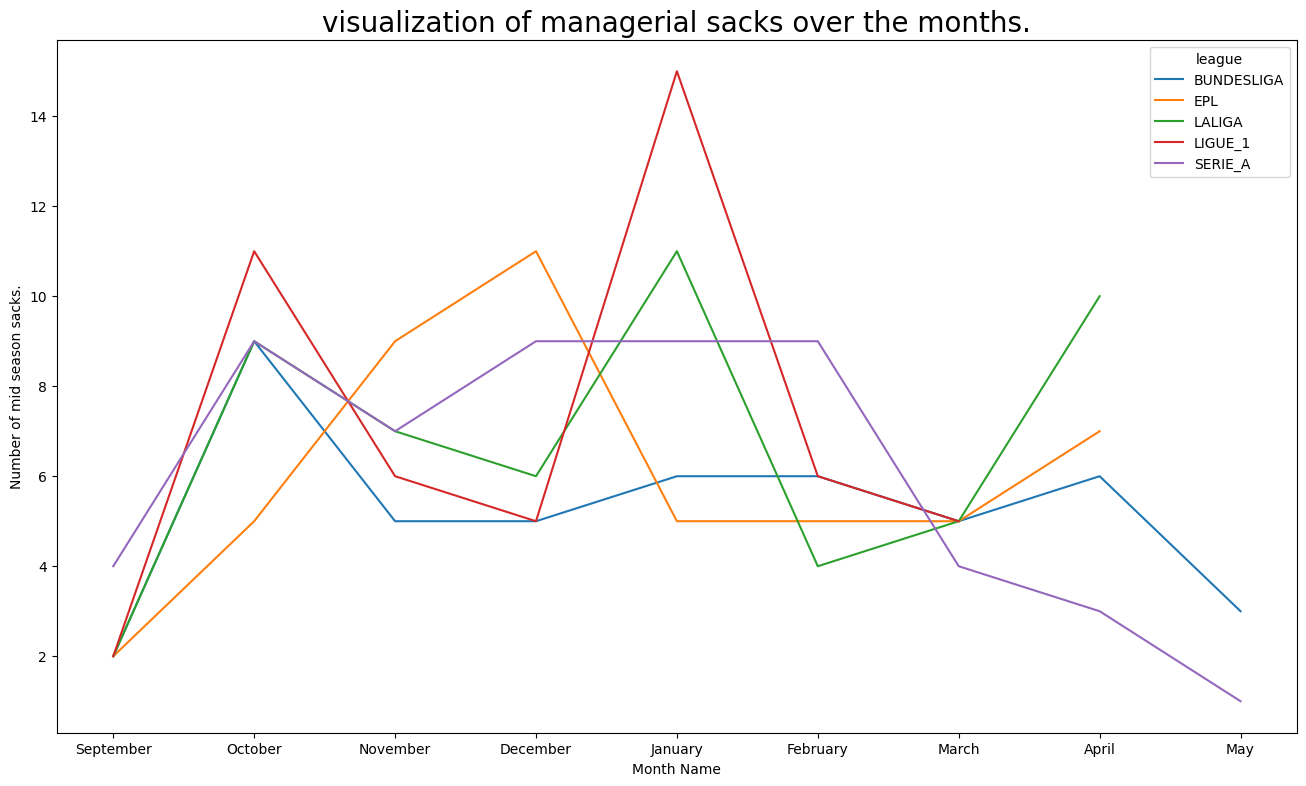

In [85]:
# Firstm get all entries where midseason sack has happened.
full_matches_timeline = pd.concat([team_timeline_classification[k] for k in team_timeline_classification.keys() ])
full_matches_timeline_sacks_midseason = full_matches_timeline[(full_matches_timeline.is_mid_season_sack==True) & (full_matches_timeline.manager_type == 'PERMANENT')]
full_matches_timeline_sacks_midseason['month_name'] = pd.to_datetime(full_matches_timeline_sacks_midseason.date).dt.month_name()
league_counts_mid_season_sacks = full_matches_timeline_sacks_midseason.groupby(['league', 'month_name'])['date'].count().reset_index(drop=False)
ordered_months_name = ['September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May']
league_counts_mid_season_sacks['month_name_ordered'] = pd.Categorical(league_counts_mid_season_sacks['month_name'], categories=ordered_months_name, ordered=True)
plt.figure(figsize=(16,9))
sns.lineplot(data=league_counts_mid_season_sacks, x='month_name_ordered', y='date', hue='league')
plt.xlabel('Month Name')
plt.ylabel('Number of mid season sacks.')
plt.title('visualization of managerial sacks over the months.', fontsize=20)

### 3. Earliest Sacked Manager

In [31]:
full_matches_timeline_sacks_midseason[(full_matches_timeline_sacks_midseason.month_name == 'April') & (full_matches_timeline_sacks_midseason.league=='EPL')][['date', 'manager', 'home_team', 'away_team', 'home_manager', 'away_manager']].sort_values(['date'])

,date,manager,home_team,away_team,home_manager,away_manager
32,2018-04-07,Darren Moore,West Brom,Swansea City,Darren Moore,Carlos Carvalhal
146,2021-04-21,Ryan Mason,Tottenham,Southampton,Ryan Mason,Ralph Hasenhüttl
182,2022-04-17,Michael Jackson,West Ham,Burnley,David Moyes,Michael Jackson
218,2023-04-01,Roy Hodgson,Crystal Palace,Leicester City,Roy Hodgson,Brendan Rodgers
219,2023-04-08,Frank Lampard,Wolves,Chelsea,Lopetegui,Frank Lampard
220,2023-04-15,Dean Smith,Manchester City,Leicester City,Pep Guardiola,Dean Smith
222,2023-04-27,Ryan Mason,Tottenham,Manchester Utd,Ryan Mason,Erik ten Hag


### 4. Manager Bounce Effect - calculation and does it work.












































-

1. League comparison of bounce.
2. Home and away bounce effect.
3. Interim vs permanent manager bounce effect.
4. Bounce effect for n matches. -- How long does the bounce last, if any?

In [32]:
manager_timeline_df.head()

,name,team,start_date,end_date,home_wins,away_wins,home_loss,away_loss,home_draws,away_draws,...,median_xg_created_in_away_wins,median_xg_faced_in_away_wins,median_xg_created_in_home_draws,median_xg_faced_in_home_draws,median_xg_created_in_away_draws,median_xg_faced_in_away_draws,median_xg_created_in_home_loss,median_xg_faced_in_home_loss,median_xg_created_in_away_loss,median_xg_faced_in_away_loss
0,Igor Tudor,Hellas Verona,2021-09-19,2022-05-21,9,5,5,5,3,8,...,2.0,1.4,1.30,0.90,1.15,1.25,1.00,1.10,0.80,1.60
1,Igor Tudor,Udinese,2018-04-29,2019-10-30,7,3,4,6,2,3,...,1.8,1.8,0.75,1.35,1.00,1.50,0.85,1.40,0.50,1.50
2,Igor Tudor,Marseille,2022-08-07,2023-06-03,10,12,5,4,4,3,...,1.6,1.1,1.60,1.35,0.90,1.10,1.70,1.00,1.25,1.20
3,Heiko Butscher,Bochum,2022-09-18,2022-09-18,0,0,0,0,1,0,...,0.0,0.0,0.20,2.10,0.00,0.00,0.00,0.00,0.00,0.00
4,Christophe Pélissier,Lorient,2020-08-23,2022-05-21,16,3,14,22,8,13,...,2.5,0.3,0.85,1.00,0.80,1.00,0.85,1.45,0.80,1.75


In [33]:
everton = team_timeline_classification['Everton']
everton = everton.sort_values(['date'])

In [34]:
everton_mid_sack_index = list(everton[everton.is_mid_season_sack==True].index)

In [35]:
def create_bounce_entry_for_team(team, num_matches=1):
  team_df = team_timeline_classification[team]
  team_df = team_df.sort_values(['date'])
  team_df_new_manager_index = list(team_df[team_df.is_mid_season_sack==True].index)
  team_bounce_stats = []
  for idx in team_df_new_manager_index:
    new_manager = team_df.iloc[idx]['manager']
    new_manager_type = team_df.iloc[idx]['manager_type']
    old_manager = team_df.iloc[idx-1]['manager']
    old_manager_type = team_df.iloc[idx-1]['manager_type']
    new_manager_matches = team_df.iloc[idx: idx+num_matches]
    old_manager_matches = team_df.iloc[(idx-num_matches-1) if (idx-num_matches-1) >=0 else 0: idx-1]
    new_manager_stats = add_suffix_to_all_keys(get_manager_stats_for_matches(new_manager_matches,new_manager, team), suffix='_new')
    old_manager_stats = add_suffix_to_all_keys(get_manager_stats_for_matches(old_manager_matches,old_manager, team), suffix='_old')
    bounce_stats = {**new_manager_stats, **old_manager_stats}
    bounce_stats['league'] = list(team_df['league'].unique())[0]
    bounce_stats['old_manager_type'] = old_manager_type
    bounce_stats['new_manager_type'] = new_manager_type
    team_bounce_stats.append(bounce_stats)
  return pd.DataFrame(team_bounce_stats)





In [36]:
def add_suffix_to_all_keys(d, suffix):
  new_d = {}
  for k in d.keys():
    new_d[k+suffix] = d[k]
  return new_d

### Analyzing bounce effect for first match alone

In [37]:
all_teams_bounce = []
for team in tqdm(team_timeline_classification.keys()):
  all_teams_bounce.append(create_bounce_entry_for_team(team))
all_bounce_df_first_match = pd.concat(all_teams_bounce)

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 31.45it/s]


In [38]:
all_bounce_df_first_match

,name_new,team_new,start_date_new,end_date_new,home_wins_new,away_wins_new,home_loss_new,away_loss_new,home_draws_new,away_draws_new,...,median_xg_faced_in_home_draws_old,median_xg_created_in_away_draws_old,median_xg_faced_in_away_draws_old,median_xg_created_in_home_loss_old,median_xg_faced_in_home_loss_old,median_xg_created_in_away_loss_old,median_xg_faced_in_away_loss_old,league,old_manager_type,new_manager_type
0,David Gallego,Espanyol,2018-04-22,2018-04-22,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.6,0.7,LALIGA,PERMANENT,INTERIM
1,Antonio Clavero,Espanyol,2018-05-13,2018-05-13,1,0,0,0,0,0,...,1.6,0.0,0.0,0.0,0.0,0.0,0.0,LALIGA,INTERIM,INTERIM
2,Pablo Machín,Espanyol,2019-10-20,2019-10-20,0,0,1,0,0,0,...,0.0,0.0,0.0,1.3,1.8,0.0,0.0,LALIGA,PERMANENT,PERMANENT
3,Abelardo Fernández,Espanyol,2020-01-04,2020-01-04,0,0,0,0,1,0,...,0.9,0.0,0.0,0.0,0.0,0.0,0.0,LALIGA,PERMANENT,PERMANENT
4,Francisco Rufete,Espanyol,2020-06-28,2020-06-28,0,0,1,0,0,0,...,0.0,0.0,0.0,0.6,1.9,0.0,0.0,LALIGA,PERMANENT,PERMANENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Davide Nicola,Udinese,2018-12-26,2018-12-26,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.3,2.2,SERIE_A,INTERIM,INTERIM
4,Davide Nicola,Udinese,2019-02-03,2019-02-03,0,0,0,0,1,0,...,0.0,0.0,0.0,1.8,2.2,0.0,0.0,SERIE_A,INTERIM,PERMANENT
5,Igor Tudor,Udinese,2019-03-30,2019-03-30,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.2,2.3,SERIE_A,PERMANENT,PERMANENT
6,Luca Gotti,Udinese,2019-11-03,2019-11-03,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.4,5.4,SERIE_A,PERMANENT,PERMANENT


In [39]:
bounce_short_df = all_bounce_df_first_match[['name_new', 'name_old', 'home_wins_new', 'home_wins_old', 'away_wins_new', 'away_wins_old', 'home_draws_new', 'home_draws_old', 'away_draws_new', 'away_draws_old', 'home_loss_new', 'home_loss_old', 'away_loss_new', 'away_loss_old', 'team_old', 'team_new', 'league', 'new_manager_type', 'old_manager_type', 'start_date_new', 'start_date_old']]

In [40]:
bounce_short_df['wins_new'] = bounce_short_df['home_wins_new'] + bounce_short_df['away_wins_new']
bounce_short_df['wins_old'] = bounce_short_df['home_wins_old'] + bounce_short_df['away_wins_old']
bounce_short_df['draws_new'] = bounce_short_df['home_draws_new'] + bounce_short_df['away_draws_new']
bounce_short_df['draws_old'] = bounce_short_df['home_draws_old'] + bounce_short_df['away_draws_old']
bounce_short_df['loss_new'] = bounce_short_df['home_loss_new'] + bounce_short_df['away_loss_new']
bounce_short_df['loss_old'] = bounce_short_df['home_loss_old'] + bounce_short_df['away_loss_old']

In [41]:
def determine_new_bounce_result(row):
  if row['wins_new'] == 1:
    return "WIN"
  elif row['draws_new'] == 1:
    return "DRAW"
  elif row['loss_new'] == 1:
    return "LOSS"
  return None

In [42]:
def determine_new_bounce_cause(row):
  if row['wins_old'] == 1:
    return "WIN"
  elif row['draws_old'] == 1:
    return "DRAW"
  elif row['loss_old'] == 1:
    return "LOSS"
  return None

In [43]:
def determine_match_location(row):
  if row['home_wins_new'] == 1 or row['home_draws_new'] == 1 or row['home_loss_new'] == 1:
    return 'HOME'
  elif row['away_wins_new'] == 1 or row['away_draws_new'] == 1 or row['away_loss_new'] == 1:
    return 'AWAY'
  return None

In [44]:
bounce_short_df['first_bounce_effect'] = bounce_short_df.apply(lambda x: determine_new_bounce_result(x), axis=1)

In [45]:
bounce_short_df['first_bounce_cause'] = bounce_short_df.apply(lambda x: determine_new_bounce_cause(x), axis=1)

In [46]:
bounce_short_df['match_location'] = bounce_short_df.apply(lambda x: determine_match_location(x), axis=1)

In [47]:
bounce_short_df['first_bounce_effect'].value_counts()

first_bounce_effect
LOSS    133
DRAW     99
WIN      96
Name: count, dtype: int64

In [48]:
bounce_short_df['first_bounce_cause'].value_counts()

first_bounce_cause
LOSS    208
DRAW     89
WIN      31
Name: count, dtype: int64

In [49]:
bounce_transitions = bounce_short_df.groupby(['first_bounce_cause', 'first_bounce_effect'])['name_new'].count().reset_index(drop=False)
bounce_transitions.columns = ['old_manager_last_game_result', 'new_manager_first_game_result', 'counts']

In [50]:
bounce_transitions

,old_manager_last_game_result,new_manager_first_game_result,counts
0,DRAW,DRAW,26
1,DRAW,LOSS,30
2,DRAW,WIN,33
3,LOSS,DRAW,64
4,LOSS,LOSS,91
5,LOSS,WIN,53
6,WIN,DRAW,9
7,WIN,LOSS,12
8,WIN,WIN,10


In [51]:
bounce_short_df['year'] = bounce_short_df['start_date_new'].dt.year

In [52]:
def determine_bounce(row):
  bounce = False
  if (row['first_bounce_effect'] == 'WIN' and row['first_bounce_cause'] == 'LOSS') or \
      (row['first_bounce_effect'] == 'DRAW' and row['first_bounce_cause'] == 'LOSS') or \
      (row['first_bounce_effect'] == 'WIN' and row['first_bounce_cause'] == 'DRAW'):
      bounce = True
  return bounce

In [53]:
bounce_short_df['bounce_effect'] = bounce_short_df.apply(lambda x: determine_bounce(x), axis=1)

In [54]:
bounce_short_df['bounce_value'] = bounce_short_df['bounce_effect'].apply(lambda x: 'Bounce' if x else 'No-Bounce')

### Visualization starts here

In [55]:
viz_df = bounce_short_df.copy()

In [56]:
viz_df['bounce_value'] = viz_df['bounce_value'].astype('category')
viz_df['league'] = viz_df['league'].astype('category')
viz_df['match_location'] = viz_df['match_location'].astype('category')
viz_df['new_manager_type'] = viz_df['new_manager_type'].astype('category')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


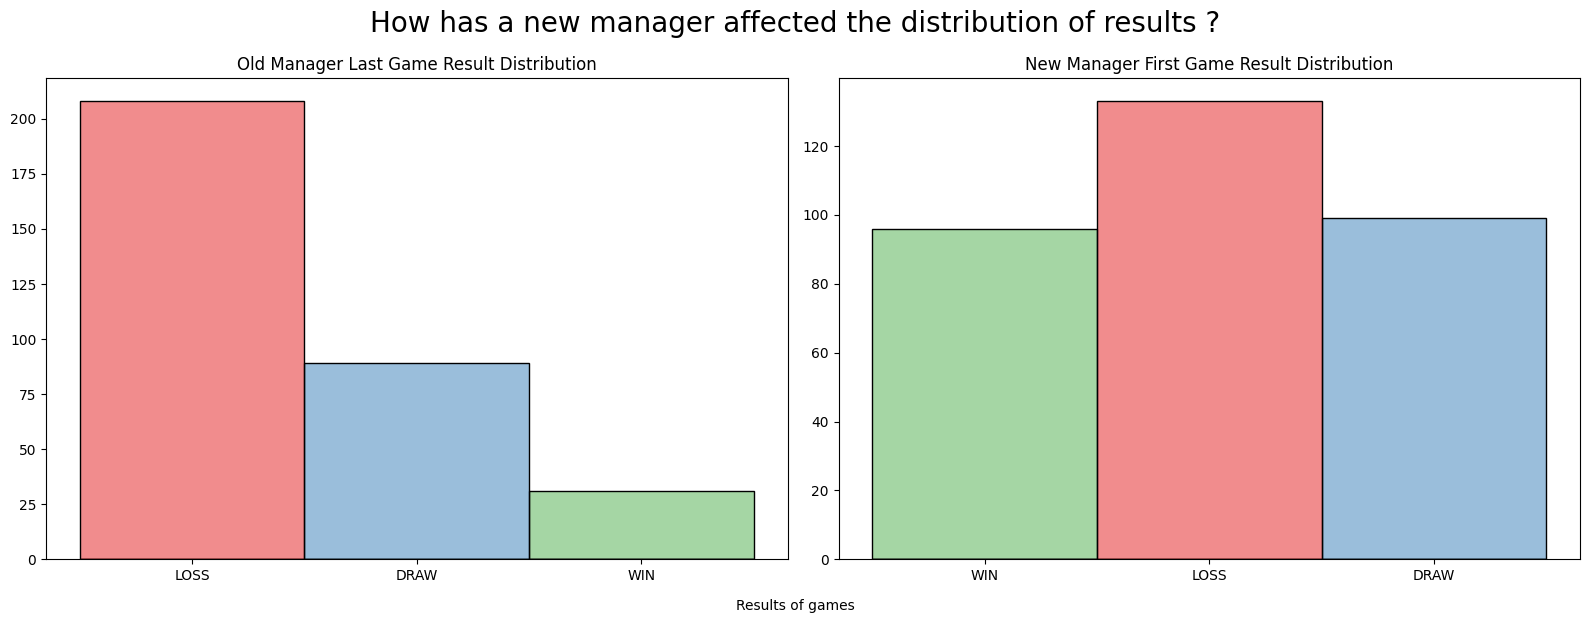

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
#sns.set(style='whitegrid')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

hue_order = ['LOSS', 'DRAW', 'WIN']
set1_colors = sns.color_palette('Set1')
category_colors = {'LOSS': set1_colors[0],  # Red from Set1 palette
                   'DRAW': set1_colors[1],
                    'WIN': set1_colors[2]}    # Blue from Set1 palette

# Plot the first displot on the first subplot
sns.histplot(data=viz_df, x='first_bounce_cause', hue="first_bounce_cause", hue_order = hue_order, palette=category_colors, ax=axes[0])
axes[0].set_title('Old Manager Last Game Result Distribution')
axes[0].set_xlabel('')  # Remove x-axis label
axes[0].set_ylabel('')  # Remove y-axis label

# Plot the second displot on the second subplot
sns.histplot(data=viz_df, x='first_bounce_effect', hue = "first_bounce_effect", hue_order = hue_order, palette= category_colors, ax=axes[1])
axes[1].set_title('New Manager First Game Result Distribution')
axes[1].set_xlabel('')  # Remove x-axis label
axes[1].set_ylabel('')  # Remove y-axis label


axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)


# Set common labels and title
fig.text(0.5, -0.02, 'Results of games', ha='center')
fig.suptitle('How has a new manager affected the distribution of results ?', fontsize=20)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Text(0.5, 1.0, 'New Manager Bounce - How Consistently has it occured ?')

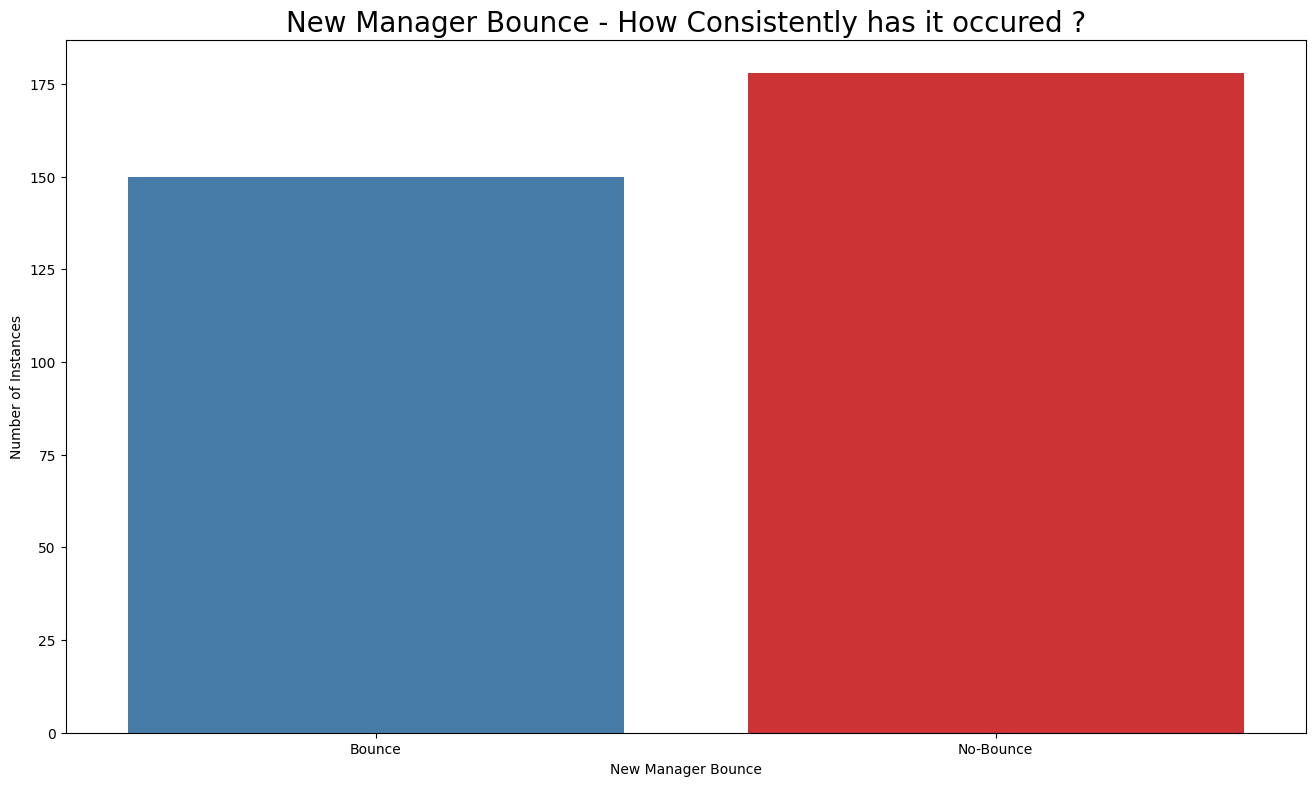

In [87]:
plt.figure(figsize=(16,9))
# Define custom color palette

# Get colors from the Set1 palette
set1_colors = sns.color_palette('Set1')

# Define a dictionary to map categories to colors
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                   'Bounce': set1_colors[1]}    # Blue from Set1 palette
sns.countplot(data=viz_df, x='bounce_value', palette=category_colors)
plt.xlabel('New Manager Bounce')
plt.ylabel('Number of Instances')
plt.title('New Manager Bounce - How Consistently has it occured ?', fontsize=20)

Text(0.5, 1.0, 'How has New Manager bounce differed in the years ?')

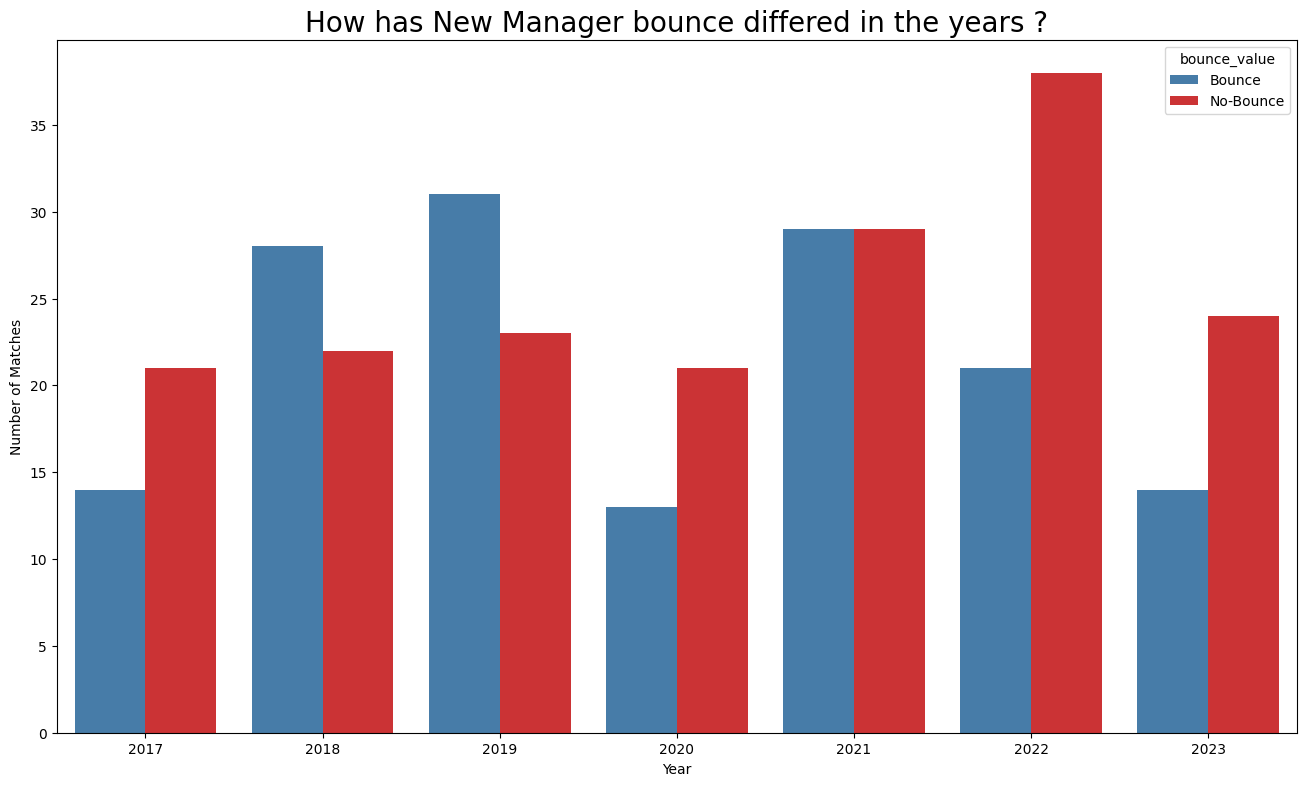

In [88]:
plt.figure(figsize=(16,9))
# Define a dictionary to map categories to colors
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                   'Bounce': set1_colors[1]}    # Blue from Set1 palette
sns.countplot(data=viz_df, x='year', hue='bounce_value', palette=category_colors)
plt.ylabel('Number of Matches')
plt.xlabel('Year')
plt.title('How has New Manager bounce differed in the years ?', fontsize=20)

Text(0.5, 1.0, 'How has New Manager bounce differed in the different european leagues ?')

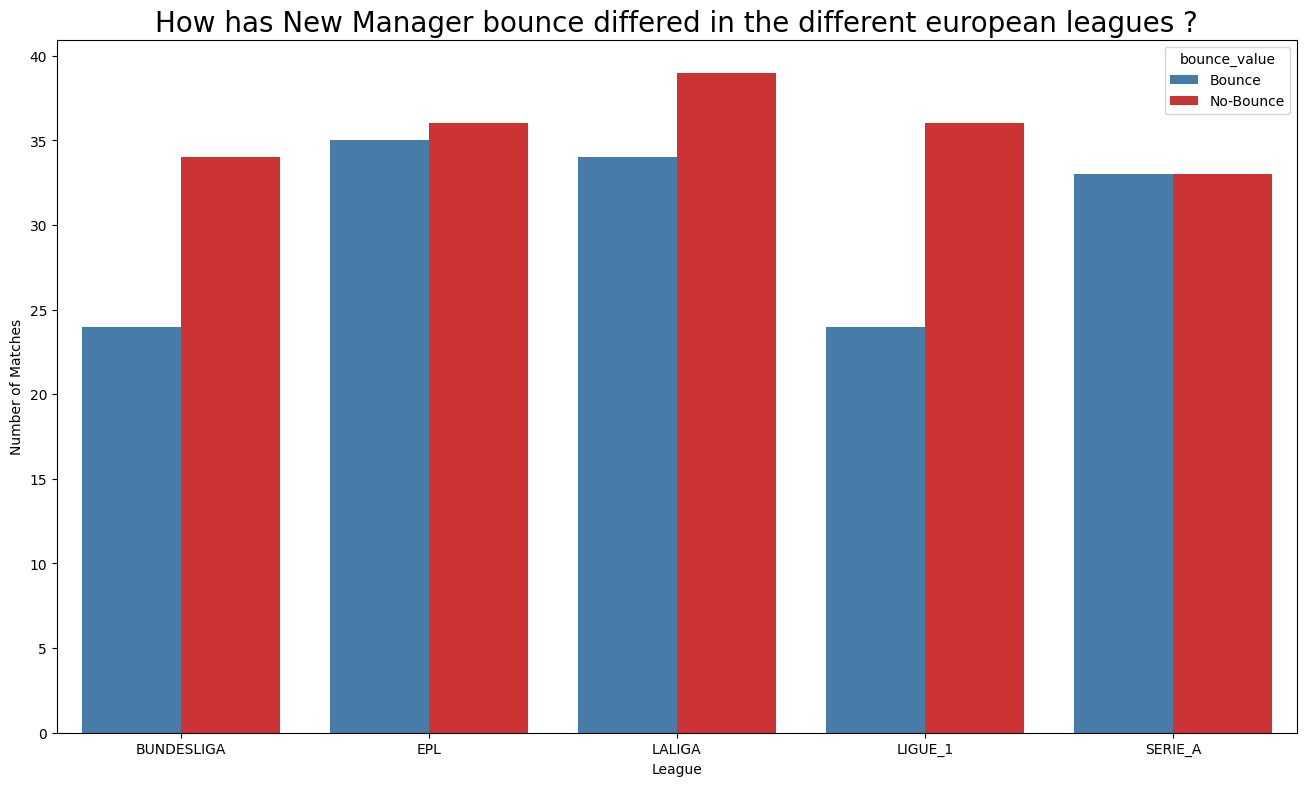

In [89]:
plt.figure(figsize=(16,9))
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                   'Bounce': set1_colors[1]}    # Blue from Set1 palette
sns.countplot(data=viz_df, x='league', hue='bounce_value', palette=category_colors)
plt.ylabel('Number of Matches')
plt.xlabel('League')
plt.title('How has New Manager bounce differed in the different european leagues ?', fontsize=20)

Text(0.5, 1.0, 'Has the type of manager affected New Manager Bounce ?')

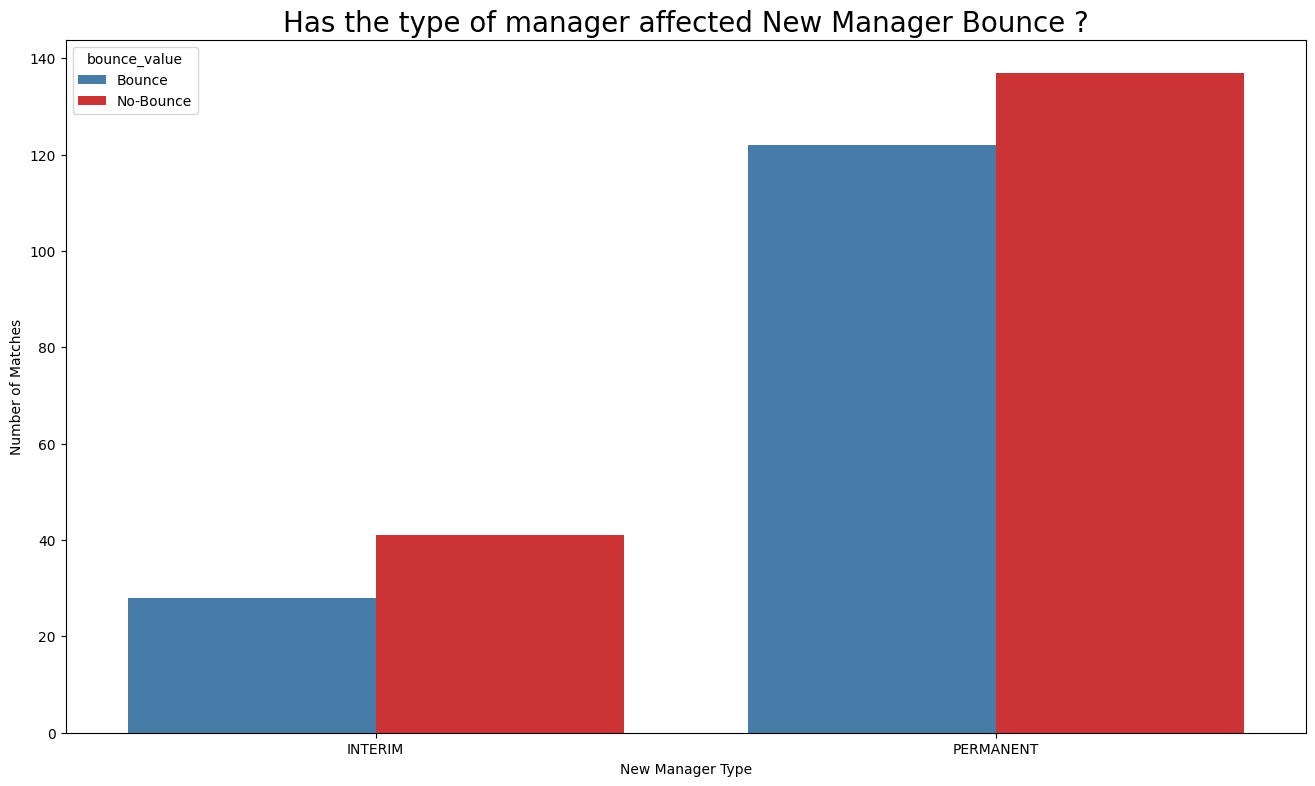

In [90]:
plt.figure(figsize=(16,9))
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                   'Bounce': set1_colors[1]}    # Blue from Set1 palette
sns.countplot(data=viz_df, x='new_manager_type', hue='bounce_value', palette=category_colors)
plt.xlabel("New Manager Type")
plt.ylabel("Number of Matches")
plt.title("Has the type of manager affected New Manager Bounce ?", fontsize=20)

Text(0.5, 1.0, 'Does the location of the first match affect New Manager Bounce ?')

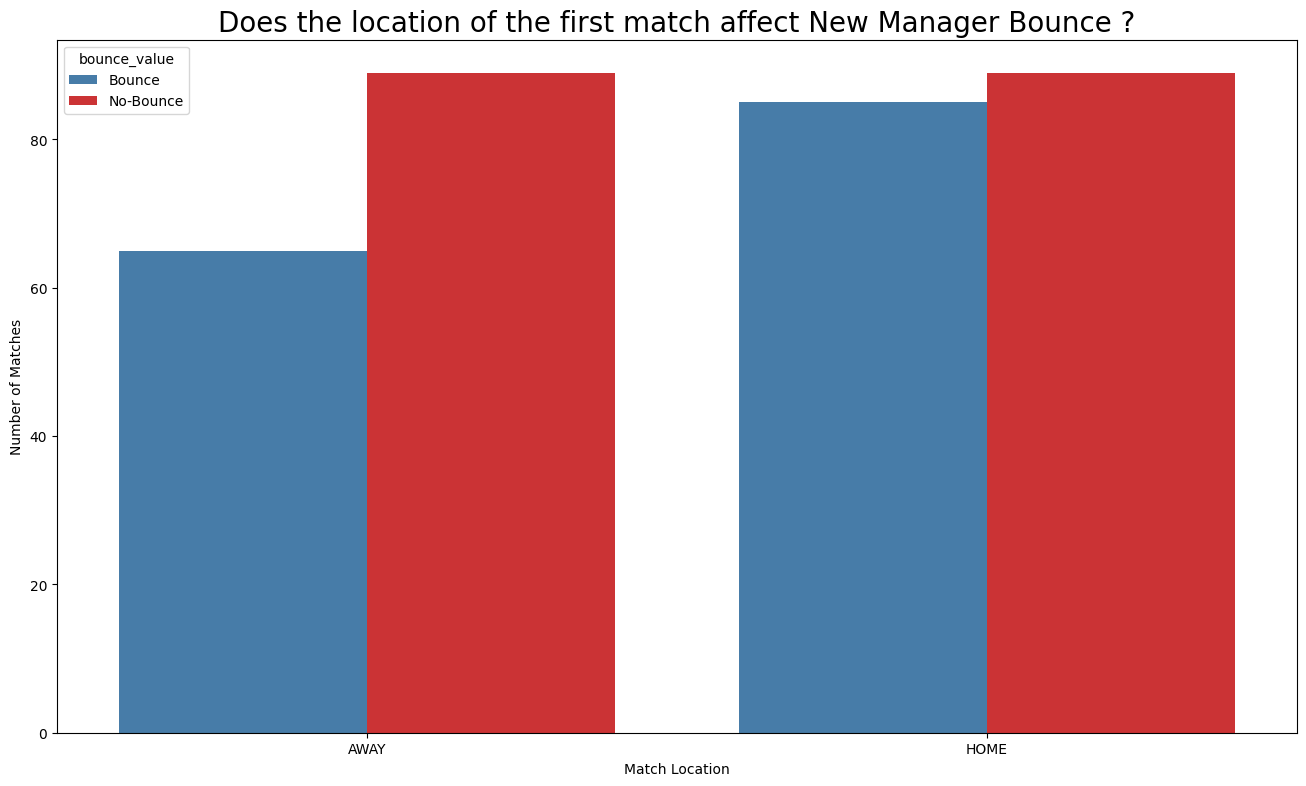

In [91]:
plt.figure(figsize=(16,9))
ategory_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                   'Bounce': set1_colors[1]}    # Blue from Set1 palette
sns.countplot(data=viz_df, x='match_location', hue='bounce_value', palette=category_colors)
plt.xlabel("Match Location")
plt.ylabel("Number of Matches")
plt.title("Does the location of the first match affect New Manager Bounce ?", fontsize=20)

In [63]:
def countplot_wrapper(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

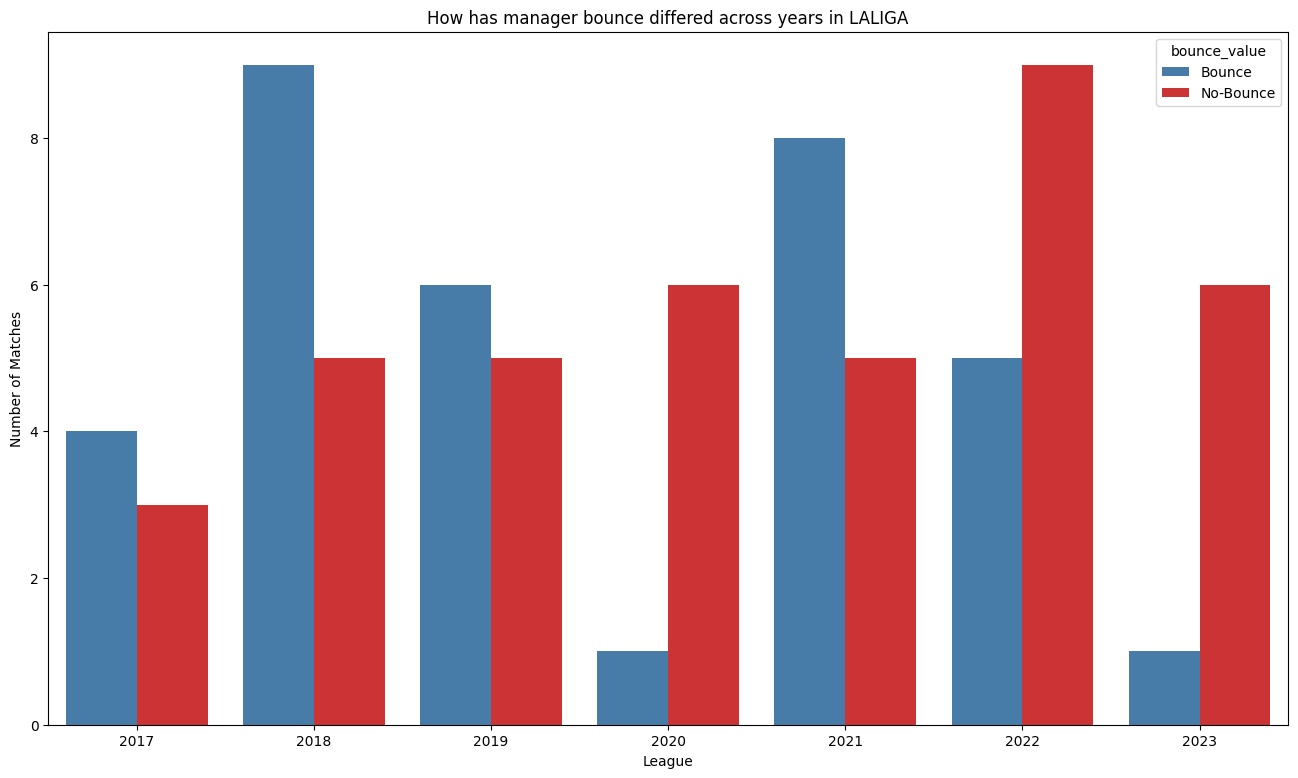

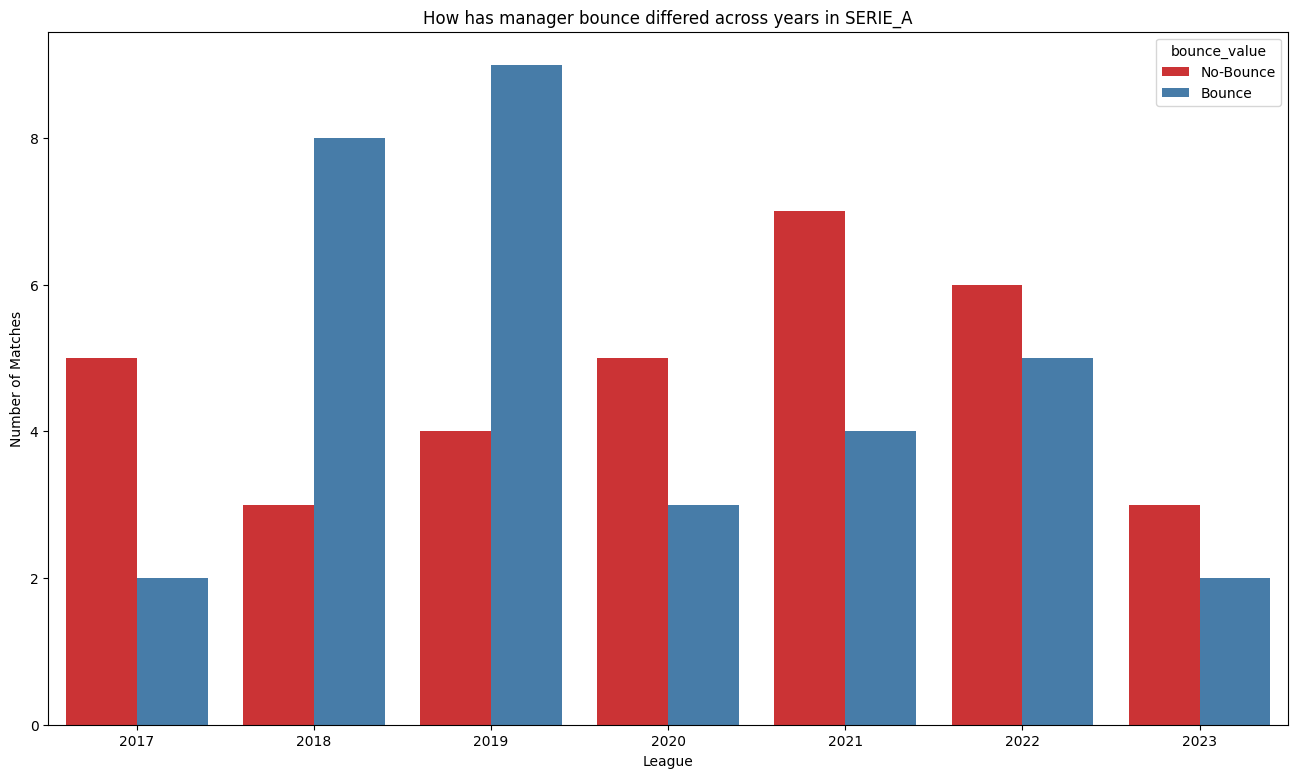

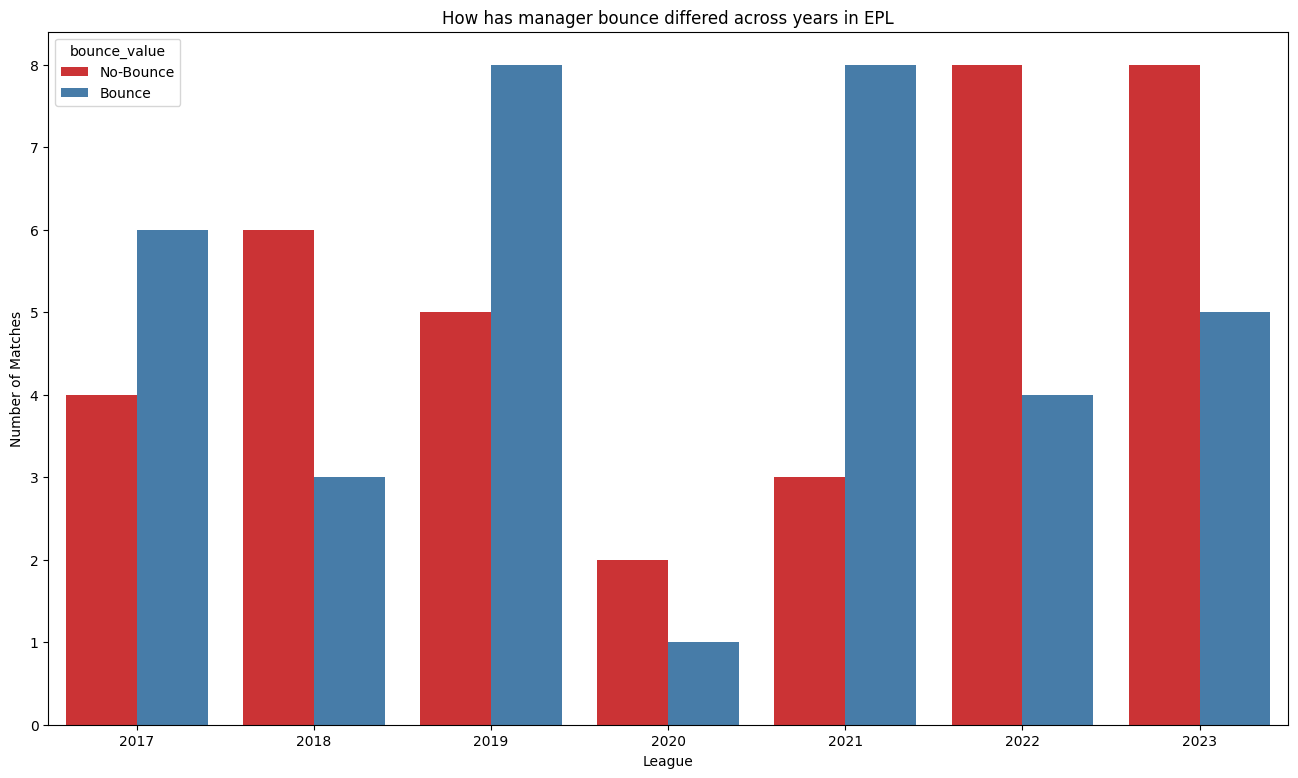

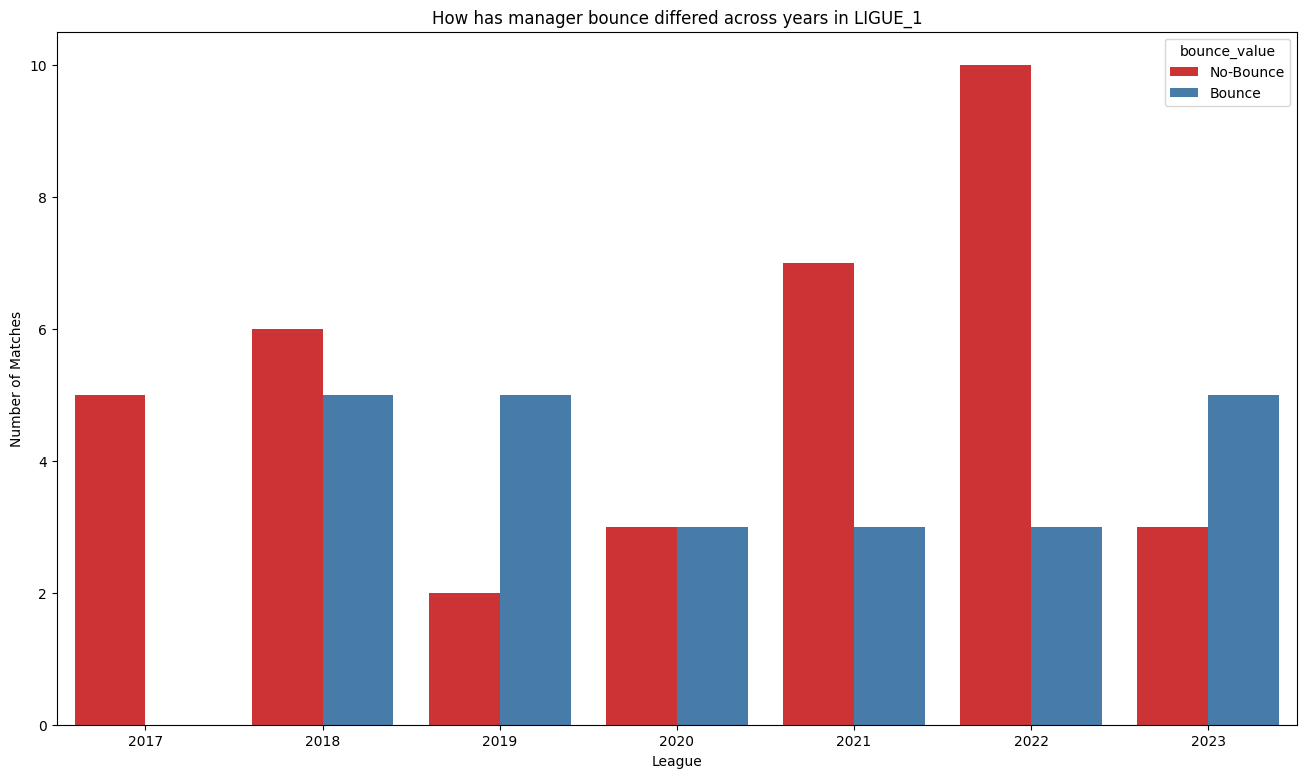

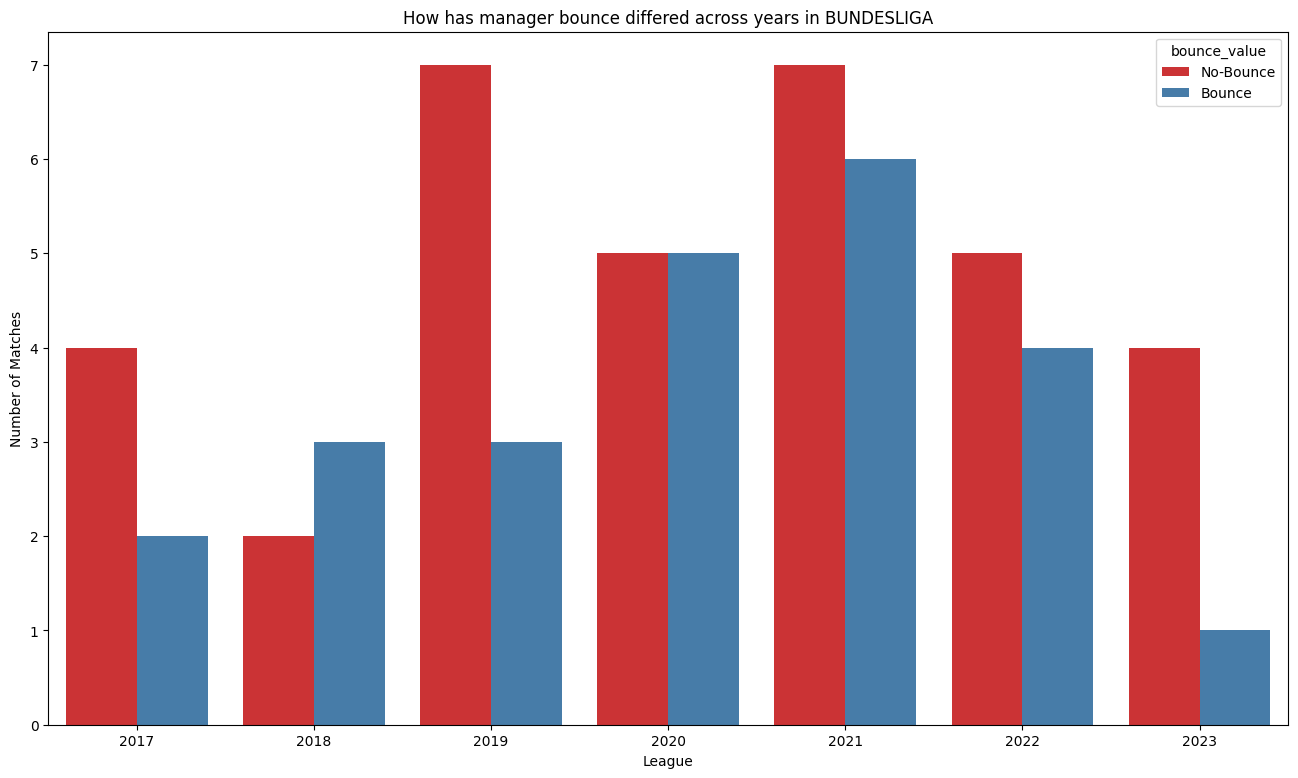

In [64]:
for league in bounce_short_df['league'].unique():
    plt.figure(figsize=(16, 9))
    category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                       'Bounce': set1_colors[1]}    # Blue from Set1 palette
    df = bounce_short_df[bounce_short_df.league==league]
    sns.countplot(data=df, x='year', hue='bounce_value', palette=category_colors)
    plt.ylabel('Number of Matches')
    plt.xlabel('League')
    plt.title(f'How has manager bounce differed across years in {league}')

<Figure size 1600x1200 with 0 Axes>

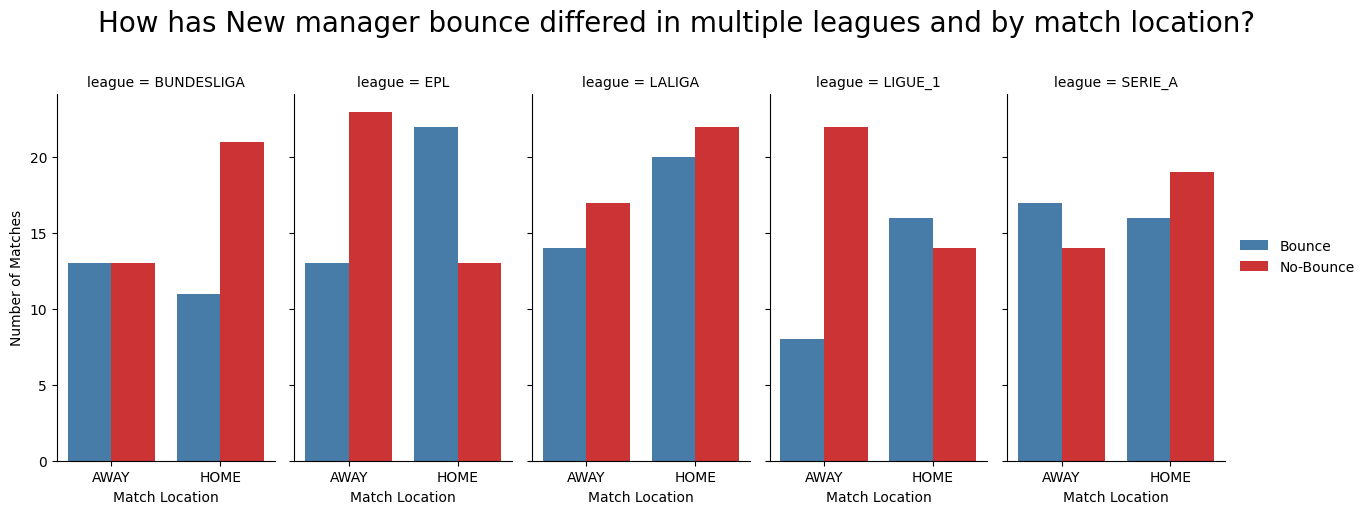

In [92]:
plt.figure(figsize=(16,12))

pl = sns.FacetGrid(data=viz_df, col='league', height=5, aspect=0.5)
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                       'Bounce': set1_colors[1]}    # Blue from 
pl = pl.map(countplot_wrapper, 'match_location', 'bounce_value', palette=category_colors)
pl.add_legend()
# Add a common title above the FacetGrid
pl.set_axis_labels('Match Location', 'Number of Matches')

plt.suptitle('How has New manager bounce differed in multiple leagues and by match location?', y=1.02, fontsize=20)

# Adjust spacing between facets to avoid overlap
plt.subplots_adjust(top=0.85)  # Adjust the top margin


In [66]:
bounce_short_df.groupby(['league', 'match_location', 'bounce_value']).size()

league      match_location  bounce_value
BUNDESLIGA  AWAY            Bounce          13
                            No-Bounce       13
            HOME            Bounce          11
                            No-Bounce       21
EPL         AWAY            Bounce          13
                            No-Bounce       23
            HOME            Bounce          22
                            No-Bounce       13
LALIGA      AWAY            Bounce          14
                            No-Bounce       17
            HOME            Bounce          20
                            No-Bounce       22
LIGUE_1     AWAY            Bounce           8
                            No-Bounce       22
            HOME            Bounce          16
                            No-Bounce       14
SERIE_A     AWAY            Bounce          17
                            No-Bounce       14
            HOME            Bounce          16
                            No-Bounce       19
dtype: int64

<Figure size 1600x900 with 0 Axes>

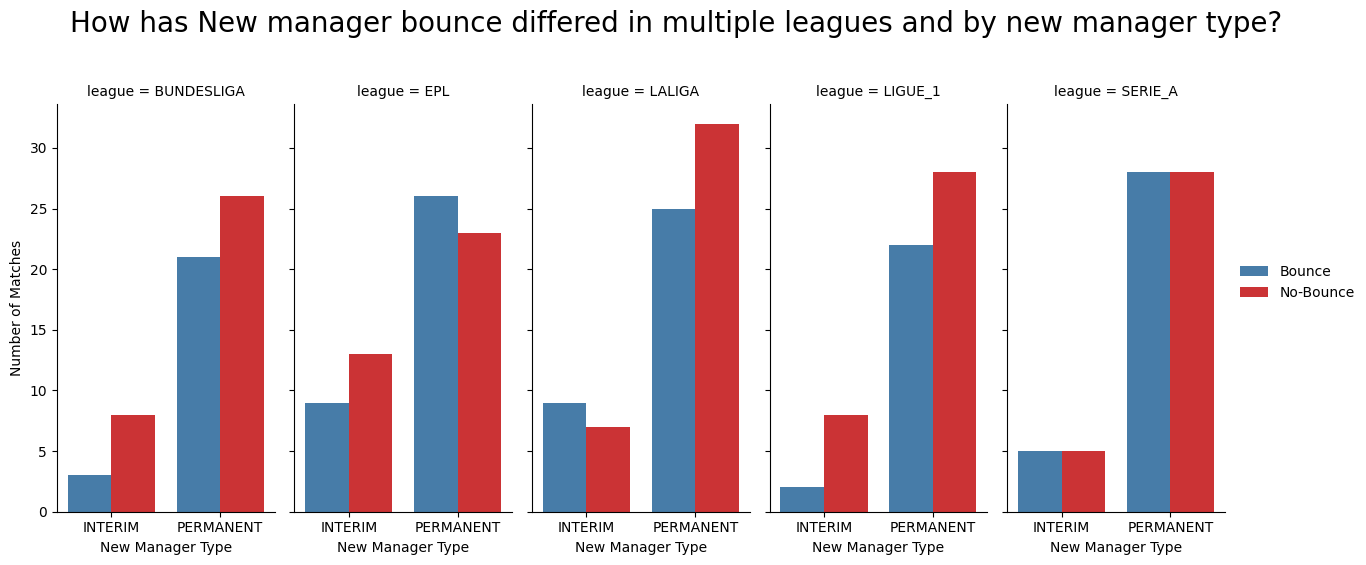

In [95]:
plt.figure(figsize=(16,9))

pl = sns.FacetGrid(data=viz_df, col='league', height=5, aspect=0.5)
category_colors = {'No-Bounce': set1_colors[0],  # Red from Set1 palette
                       'Bounce': set1_colors[1]}
pl = pl.map(countplot_wrapper, 'new_manager_type', 'bounce_value', palette=category_colors)
pl.set_axis_labels('New Manager Type', 'Number of Matches')
plt.suptitle('How has New manager bounce differed in multiple leagues and by new manager type?', y=1.12, fontsize=20)

pl.add_legend()

In [68]:
bounce_short_df.groupby(['league', 'new_manager_type', 'bounce_value']).size()

league      new_manager_type  bounce_value
BUNDESLIGA  INTERIM           Bounce           3
                              No-Bounce        8
            PERMANENT         Bounce          21
                              No-Bounce       26
EPL         INTERIM           Bounce           9
                              No-Bounce       13
            PERMANENT         Bounce          26
                              No-Bounce       23
LALIGA      INTERIM           Bounce           9
                              No-Bounce        7
            PERMANENT         Bounce          25
                              No-Bounce       32
LIGUE_1     INTERIM           Bounce           2
                              No-Bounce        8
            PERMANENT         Bounce          22
                              No-Bounce       28
SERIE_A     INTERIM           Bounce           5
                              No-Bounce        5
            PERMANENT         Bounce          28
                          

In [69]:
gg = bounce_short_df.groupby(['league', 'new_manager_type', 'match_location', 'bounce_value'])['name_new'].size().reset_index()

In [70]:
gg_sums = bounce_short_df.groupby(['league', 'new_manager_type', 'match_location'])['name_new'].size().reset_index(drop=False)

In [71]:
gg_sums

,league,new_manager_type,match_location,name_new
0,BUNDESLIGA,INTERIM,AWAY,5
1,BUNDESLIGA,INTERIM,HOME,6
2,BUNDESLIGA,PERMANENT,AWAY,21
3,BUNDESLIGA,PERMANENT,HOME,26
4,EPL,INTERIM,AWAY,13
5,EPL,INTERIM,HOME,9
6,EPL,PERMANENT,AWAY,23
7,EPL,PERMANENT,HOME,26
8,LALIGA,INTERIM,AWAY,6
9,LALIGA,INTERIM,HOME,10


In [72]:
gg

,league,new_manager_type,match_location,bounce_value,name_new
0,BUNDESLIGA,INTERIM,AWAY,Bounce,1
1,BUNDESLIGA,INTERIM,AWAY,No-Bounce,4
2,BUNDESLIGA,INTERIM,HOME,Bounce,2
3,BUNDESLIGA,INTERIM,HOME,No-Bounce,4
4,BUNDESLIGA,PERMANENT,AWAY,Bounce,12
5,BUNDESLIGA,PERMANENT,AWAY,No-Bounce,9
6,BUNDESLIGA,PERMANENT,HOME,Bounce,9
7,BUNDESLIGA,PERMANENT,HOME,No-Bounce,17
8,EPL,INTERIM,AWAY,Bounce,5
9,EPL,INTERIM,AWAY,No-Bounce,8


In [73]:
gg.columns = ['league', 'new_manager_type', 'match_location', 'bounce_value', 'size']
gg_sums.columns = ['league', 'new_manager_type', 'match_location', 'sum']

In [74]:
merged_prop = gg_sums.merge(gg, on = ['league', 'new_manager_type', 'match_location'], how='inner')
merged_prop['prop'] = round((merged_prop['size']/merged_prop['sum'])*100, 2)

In [75]:
merged_prop = merged_prop.sort_values(['league', 'prop'], ascending=False)

In [76]:
merged_prop.columns

Index(['league', 'new_manager_type', 'match_location', 'sum', 'bounce_value',
       'size', 'prop'],
      dtype='object')

In [77]:
merged_prop.sort_values(["prop"], ascending=False)

,league,new_manager_type,match_location,sum,bounce_value,size,prop
25,LIGUE_1,INTERIM,AWAY,7,No-Bounce,6,85.71
1,BUNDESLIGA,INTERIM,AWAY,5,No-Bounce,4,80.00
18,LALIGA,INTERIM,HOME,10,Bounce,7,70.00
29,LIGUE_1,PERMANENT,AWAY,23,No-Bounce,16,69.57
14,EPL,PERMANENT,HOME,26,Bounce,18,69.23
27,LIGUE_1,INTERIM,HOME,3,No-Bounce,2,66.67
17,LALIGA,INTERIM,AWAY,6,No-Bounce,4,66.67
3,BUNDESLIGA,INTERIM,HOME,6,No-Bounce,4,66.67
7,BUNDESLIGA,PERMANENT,HOME,26,No-Bounce,17,65.38
13,EPL,PERMANENT,AWAY,23,No-Bounce,15,65.22


In [78]:
merged_prop[merged_prop['sum'] >= 10].sort_values(["prop"], ascending=False)

,league,new_manager_type,match_location,sum,bounce_value,size,prop
18,LALIGA,INTERIM,HOME,10,Bounce,7,70.00
29,LIGUE_1,PERMANENT,AWAY,23,No-Bounce,16,69.57
14,EPL,PERMANENT,HOME,26,Bounce,18,69.23
7,BUNDESLIGA,PERMANENT,HOME,26,No-Bounce,17,65.38
13,EPL,PERMANENT,AWAY,23,No-Bounce,15,65.22
9,EPL,INTERIM,AWAY,13,No-Bounce,8,61.54
23,LALIGA,PERMANENT,HOME,32,No-Bounce,19,59.38
4,BUNDESLIGA,PERMANENT,AWAY,21,Bounce,12,57.14
30,LIGUE_1,PERMANENT,HOME,27,Bounce,15,55.56
36,SERIE_A,PERMANENT,AWAY,26,Bounce,14,53.85


In [79]:
merged_prop[merged_prop['sum'] >= 10].groupby(['league']).head(3)

,league,new_manager_type,match_location,sum,bounce_value,size,prop
36,SERIE_A,PERMANENT,AWAY,26,Bounce,14,53.85
39,SERIE_A,PERMANENT,HOME,30,No-Bounce,16,53.33
38,SERIE_A,PERMANENT,HOME,30,Bounce,14,46.67
29,LIGUE_1,PERMANENT,AWAY,23,No-Bounce,16,69.57
30,LIGUE_1,PERMANENT,HOME,27,Bounce,15,55.56
31,LIGUE_1,PERMANENT,HOME,27,No-Bounce,12,44.44
18,LALIGA,INTERIM,HOME,10,Bounce,7,70.00
23,LALIGA,PERMANENT,HOME,32,No-Bounce,19,59.38
21,LALIGA,PERMANENT,AWAY,25,No-Bounce,13,52.00
14,EPL,PERMANENT,HOME,26,Bounce,18,69.23


In [80]:
bounce_short_df.groupby(['league', 'new_manager_type', 'bounce_value']).size().reset_index()

,league,new_manager_type,bounce_value,0
0,BUNDESLIGA,INTERIM,Bounce,3
1,BUNDESLIGA,INTERIM,No-Bounce,8
2,BUNDESLIGA,PERMANENT,Bounce,21
3,BUNDESLIGA,PERMANENT,No-Bounce,26
4,EPL,INTERIM,Bounce,9
5,EPL,INTERIM,No-Bounce,13
6,EPL,PERMANENT,Bounce,26
7,EPL,PERMANENT,No-Bounce,23
8,LALIGA,INTERIM,Bounce,9
9,LALIGA,INTERIM,No-Bounce,7


In [81]:
bounce_short_df.to_csv('./data/bounce_data.csv', index=False)

In [82]:
bounce_short_df.columns

Index(['name_new', 'name_old', 'home_wins_new', 'home_wins_old',
       'away_wins_new', 'away_wins_old', 'home_draws_new', 'home_draws_old',
       'away_draws_new', 'away_draws_old', 'home_loss_new', 'home_loss_old',
       'away_loss_new', 'away_loss_old', 'team_old', 'team_new', 'league',
       'new_manager_type', 'old_manager_type', 'start_date_new',
       'start_date_old', 'wins_new', 'wins_old', 'draws_new', 'draws_old',
       'loss_new', 'loss_old', 'first_bounce_effect', 'first_bounce_cause',
       'match_location', 'year', 'bounce_effect', 'bounce_value'],
      dtype='object')

In [83]:
all_bounce_df_first_match.to_csv('./data/all_bounce.csv', index=False)